# Preliminary Results


In [1]:
# Load the necessary packages.
library(GGally)
library(tidyverse)
library(infer)
library(cowplot)
library(broom)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
✔ purrr   0.3.4      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [21]:
#Setting the seed.
set.seed(1234)

#Dowloading the data from the web and reading it in R.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
download.file (url,"../data/forestfires.csv" )

forest_fires_data <-read_delim("../data/forestfires.csv", skip=0, delim=",") %>%
    select(wind, area) %>%
    mutate(wind = as.numeric(wind), area = as.numeric(area)) %>% #Wrangling data and selecting columns to be used in prediction
    filter(!is.na(wind) | !is.na(area))
    
head(forest_fires_data)

Rows: 517 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


wind,area
<dbl>,<dbl>
6.7,0
0.9,0
1.3,0
4.0,0
1.8,0
5.4,0


##### Table 1: Top 6 Rows of Forest Fires Data

##### Table 2: Summary Statistics of Forest Fires Data

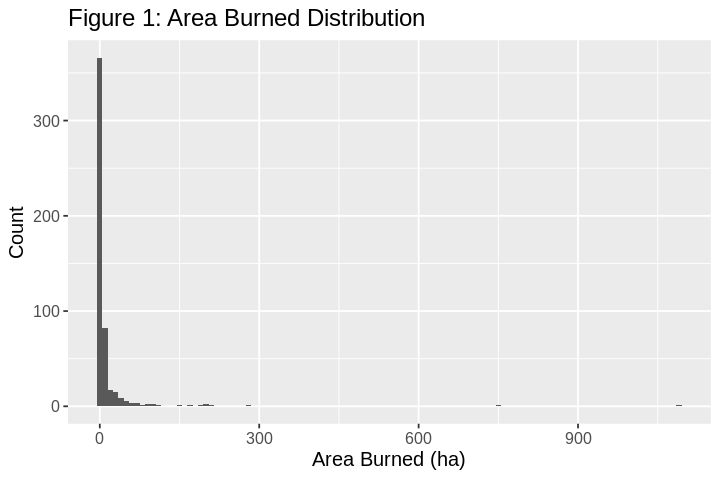

In [3]:
options(repr.plot.width = 6, repr.plot.height = 4)

#Visualizing the distribution of each variable
area_burned_plot <- forest_fires_data %>%
    ggplot(aes(x =area))+
    geom_histogram(binwidth = 10) + 
    labs(x="Area Burned (ha)", y="Count")+
    ggtitle("Figure 1: Area Burned Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 12))
area_burned_plot   

Figure 2 shows that it make sense to scale the data in a logrithmic scale.
> See https://www.programmingr.com/tutorial/log-in-r/.

In [4]:
forest_fires_data <- forest_fires_data %>%
    mutate(area_log10 = log10(1+ area))

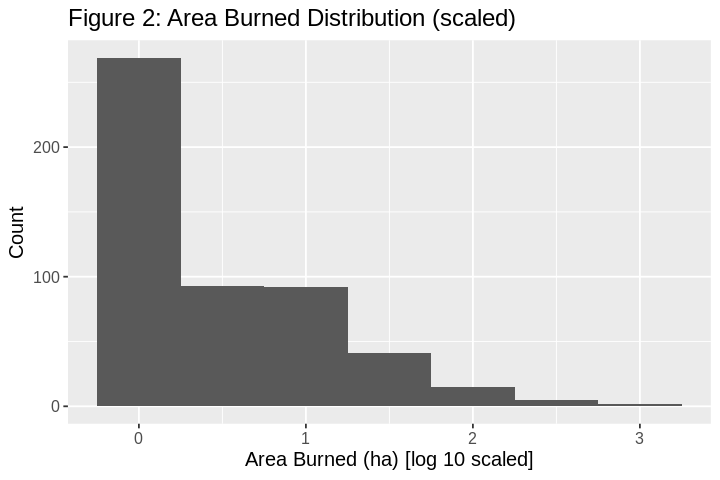

In [19]:
options(repr.plot.width = 6, repr.plot.height = 4)

area_burned_scaled_plot <- forest_fires_data %>%
    ggplot(aes(x =area_log10))+
    geom_histogram(binwidth = 0.5) + 
    labs(x="Area Burned (ha) [log 10 scaled]", y="Count")+
    ggtitle("Figure 2: Area Burned Distribution (scaled)") +
    scale_fill_discrete(name = "Month of Fires") +
    theme(text = element_text(size = 12))
area_burned_scaled_plot

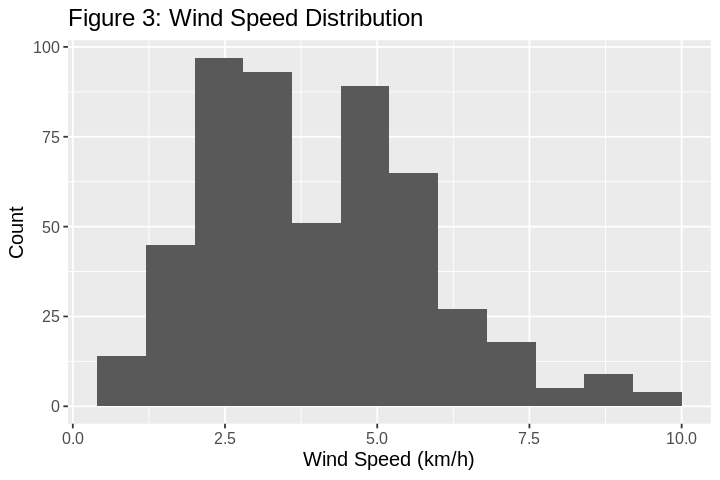

In [20]:
options(repr.plot.width = 6, repr.plot.height = 4)

wind_speed_plot <- forest_fires_data %>%
    ggplot(aes(x = wind))+
    geom_histogram(binwidth = 0.8) + 
    labs(x="Wind Speed (km/h)", y="Count")+
    ggtitle("Figure 3: Wind Speed Distribution") +
    scale_fill_discrete(name = "Month of Fires")+
    theme(text = element_text(size = 12)) 
wind_speed_plot

Based on that wind speed is almost a normal distribution (without much modification), we can safely assume that we can categorize wind speed into "high" and "low".

In [7]:
xs <- quantile(forest_fires_data$wind,c(0,1/2,1))

forest_fires_data <- forest_fires_data %>%
    mutate(category=cut(wind, breaks=xs, labels=c("low","high"),include.lowest = TRUE))
head(forest_fires_data)

month,wind,area,area_log10,category
<chr>,<dbl>,<dbl>,<dbl>,<fct>
mar,6.7,0,0,high
oct,0.9,0,0,low
oct,1.3,0,0,low
mar,4.0,0,0,low
mar,1.8,0,0,low
aug,5.4,0,0,high


In [8]:
wind_plot_categorized <- forest_fires_data %>%
    ggplot(aes(x =wind, fill = category))+
    geom_histogram(binwidth = 0.8) + 
    labs(x="Wind Speed", y="Count")+
    ggtitle("Figure 4: Wind Speed Distribution") +
    scale_fill_discrete(name = "Wind Speed Category") +
    theme(text = element_text(size = 12)) + 
    geom_vline(aes(xintercept = quantile(wind)[3]))

In [9]:
box_plot <- forest_fires_data %>%
  ggplot(aes(x = category, y = wind, fill = category)) +
  geom_boxplot() +
  labs(x="Wind Speed Category", y="Wind Speed")+
  ggtitle("Figure 5: Boxplot of Wind Speed by Category")

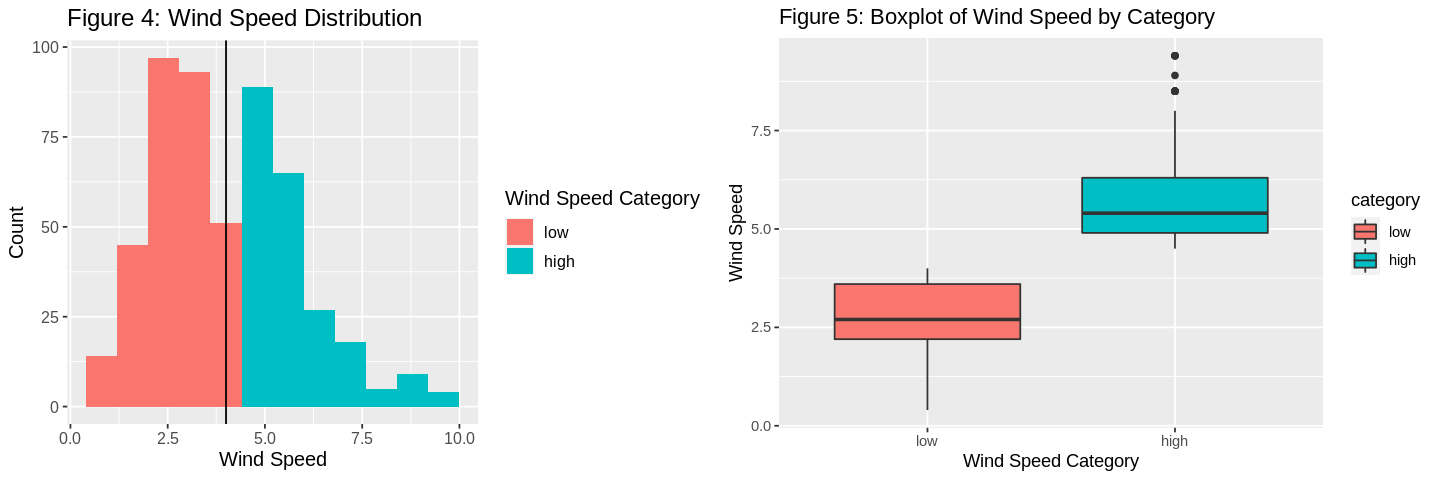

In [16]:
options(repr.plot.width = 12, repr.plot.height = 4)
plot_grid(wind_plot_categorized, box_plot)

In [12]:
forest_fires_data %>%
group_by(category) %>%
filter(category == "low") %>%
summary()

    month                wind            area            area_log10    
 Length:300         Min.   :0.400   Min.   :   0.000   Min.   :0.0000  
 Class :character   1st Qu.:2.200   1st Qu.:   0.000   1st Qu.:0.0000  
 Mode  :character   Median :2.700   Median :   0.495   Median :0.1746  
                    Mean   :2.779   Mean   :  12.615   Mean   :0.4699  
                    3rd Qu.:3.600   3rd Qu.:   6.365   3rd Qu.:0.8672  
                    Max.   :4.000   Max.   :1090.840   Max.   :3.0382  
 category  
 low :300  
 high:  0  
           
           
           
           

In [13]:
forest_fires_data %>%
group_by(category) %>%
filter(category == "high") %>%
summary()

    month                wind            area          area_log10    
 Length:217         Min.   :4.500   Min.   :  0.00   Min.   :0.0000  
 Class :character   1st Qu.:4.900   1st Qu.:  0.00   1st Qu.:0.0000  
 Mode  :character   Median :5.400   Median :  0.61   Median :0.2068  
                    Mean   :5.729   Mean   : 13.17   Mean   :0.5000  
                    3rd Qu.:6.300   3rd Qu.:  7.73   3rd Qu.:0.9410  
                    Max.   :9.400   Max.   :746.28   Max.   :2.8735  
 category  
 low :  0  
 high:217  
           
           
           
           